# Loading subsets at the I/O level

For generating subsets of data we used to abide by a workflow structure where we:

1. "Loaded" all the data lazily using `read_hipscat`
2. Filtered the data using a spatial filtering mechanism

This type of workflow is reasonable for most use cases as Dask will only actively read data from the partitions that correspond to the filtered region. However, applying a filter does not prevent Dask from constructing an initial layer of the task graph that considers all partitions in the dataset. At a certain number of partitions the task graph will be so large that it may prevent even a subset from being loaded in efficiently.

We can now load catalog subsets at the I/O level. This means that we can provide Dask with the partitions that it requires for a specific spatial region instead of letting it sort everything out. `read_hipscat(path, ...)` has been updated to `read_hipscat(path, search_filter, ...)` where search_filter is any instance of AbstractSearch.

In [1]:
import lsdb

from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch

In [2]:
# How to use the new API
example_catalog = lsdb.read_hipscat(
    path="https://epyc.astro.washington.edu/~lincc-frameworks/other_degree_surveys/ztf/ztf_object/",
    search_filter=ConeSearch(ra=-60, dec=20, radius_arcsec=1*3600)
)
example_catalog

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
npartitions=6,,,,,,,,,,,,,,,
3643412098542731264,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32
3644537998449573888,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3653545197704314880,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We will compare the performance of the spatial filters for catalogs of 3 different orders of magnitude:

- `ztf_source` of ~311 thousand partitions
- `ztf_zource` of ~42 thousand partitions
- `gaia_dr3`of ~4 thousand partitions

... and see if there is any correlation between the total number of catalog partitions and eventual performance gains.

In [3]:
catalogs = {
    "ztf_source": "/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source",
    "ztf_zource": "/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource",
    "gaia": "/epyc/data3/hipscat/catalogs/gaia_dr3/gaia",
}

### Profiling helpers

In [4]:
import os
import cProfile, pstats

from IPython.display import display, IFrame

In [5]:
def profile(catalog_name, search_type, catalog_path, search, *args):
    tuna_path = "~/.conda/envs/py310/bin/tuna"
    
    search_name = search.__class__.__name__
    search_type_name = search_type.__name__    
    
    output_dir = f"data/{catalog_name}/{search_type_name}/{search_name}"
    profile_name = f"{output_dir}/profile"
    
    os.makedirs(output_dir, exist_ok=True)
        
    # Benchmark performance with cProfile
    profiler = cProfile.Profile()
    profiler.enable()
    search_type(catalog_path, search, *args)
    profiler.disable()
    profiler.dump_stats(profile_name)
    
    # Generate static HTML dashboard
    cmd = f"{tuna_path} {profile_name} --no-browser --outdir {output_dir}"
    !{cmd}
    
    # Display dashboard
    html_path = f"{output_dir}/index.html"
    return IFrame(html_path, 950, 500)

In [6]:
def load_and_search(path, search, vertices):
    catalog = lsdb.read_hipscat(path)
    if isinstance(search, BoxSearch):
        search_method = "box"
        args = {"ra": search.ra, "dec": search.dec}
    elif isinstance(search, ConeSearch):
        search_method = "cone_search"
        args = {"ra": search.ra, "dec": search.dec, "radius_arcsec": search.radius_arcsec}
    elif isinstance(search, PolygonSearch):
        search_method = "polygon_search"
        args = {"vertices": vertices}
    search_filter = getattr(catalog, search_method)
    return search_filter(**args, fine=False)

def load_with_search(path, search):
    return lsdb.read_hipscat(path, search_filter=search)

def profile_search(search, vertices=None):
    profiles_load_and_filter = []
    profiles_load_with_filter = []
    for catalog_name, catalog_path in catalogs.items():
        frame_1 = profile(catalog_name, load_and_search, catalog_path, search, vertices)
        frame_2 = profile(catalog_name, load_with_search, catalog_path, search)
        profiles_load_and_filter.append(frame_1)
        profiles_load_with_filter.append(frame_2)
    return profiles_load_and_filter, profiles_load_with_filter

## Filtering with a box search

In [7]:
box_search = BoxSearch(ra=(340, 342), dec=(10, 20))
box_and_filter, box_with_filter = profile_search(box_search)

In [8]:
for frame in box_and_filter:
    display(frame)

In [9]:
for frame in box_with_filter:
    display(frame)

## Filtering with a cone search

In [10]:
cone_search = ConeSearch(ra=30.1, dec=20.5, radius_arcsec=3*3600)
cone_and_filter, cone_with_filter = profile_search(cone_search)

In [11]:
for frame in cone_and_filter:
    display(frame)

In [12]:
for frame in cone_with_filter:
    display(frame)

## Filtering with a polygon search

In [13]:
vertices = [(20.5, 40.1), (20.5, 35.5), (23.2, 35.5), (23.2, 40.1)]
polygon_search = PolygonSearch(vertices)
polygon_and_filter, polygon_with_filter = profile_search(polygon_search, vertices)

In [14]:
for frame in polygon_and_filter:
    display(frame)

In [15]:
for frame in polygon_with_filter:
    display(frame)

## Plotting performance changes

In [20]:
import numpy as np
import matplotlib.pyplot as plt

search_types = ["load_and_search", "load_with_search"]
search_methods = ["ConeSearch", "BoxSearch", "PolygonSearch"]

def bar_plot(performance, title):
    x = np.arange(len(performance))
    y = list(zip(*performance))

    width = 0.4
    
    plt.bar(x - width/2, y[0], width, color="orange") 
    plt.bar(x + width/2, y[1], width, color="green")

    plt.xlabel("Search method")
    plt.xticks(x, search_methods)
    plt.ylabel("Time (seconds)")
    plt.title(title)
    
    # Add legend to plot
    colors = {search_types[0]: "orange", search_types[1]: "green"}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)

    plt.show()
    
def plot_catalog_performance(catalog_name):
    performance = []
    for search_method in search_methods:
        perf = []
        for search_type in search_types:
            stats = pstats.Stats(f"data/{catalog_name}/{search_type}/{search_method}/profile")
            s = stats.get_stats_profile()
            perf.append(s.total_tt)
        speedup = round((1 - perf[1] / perf[0]) * 100, 2)
        print(f"{search_method}: {-speedup}%")
        performance.append(perf)
    bar_plot(performance, title=catalog_name)

## Performance on ZTF source

ConeSearch: -50.25%
BoxSearch: -10.83%
PolygonSearch: -28.85%


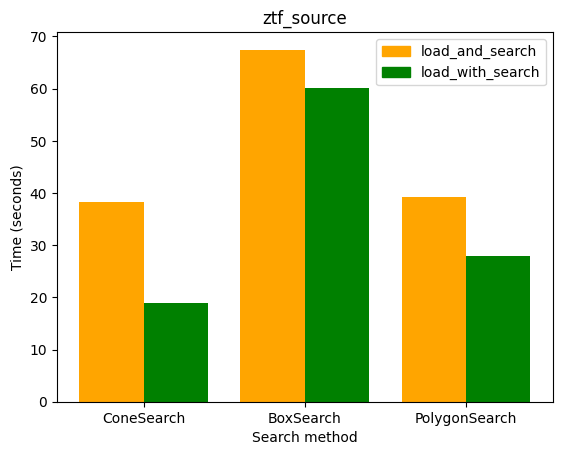

In [21]:
plot_catalog_performance("ztf_source")

## Performance on ZTF zource

ConeSearch: -53.29%
BoxSearch: -24.94%
PolygonSearch: -43.84%


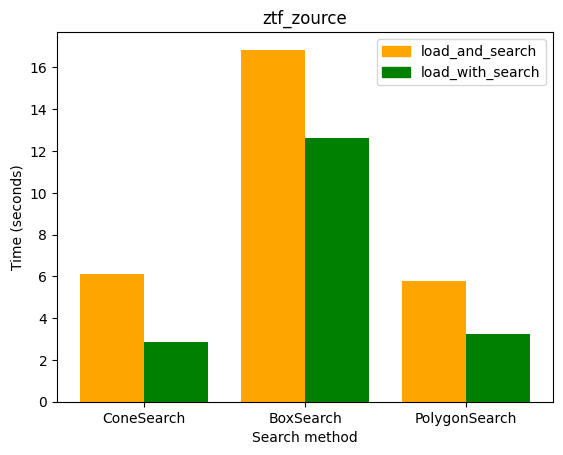

In [22]:
plot_catalog_performance("ztf_zource")

## Performance on Gaia

ConeSearch: 77.55%
BoxSearch: -13.46%
PolygonSearch: -56.16%


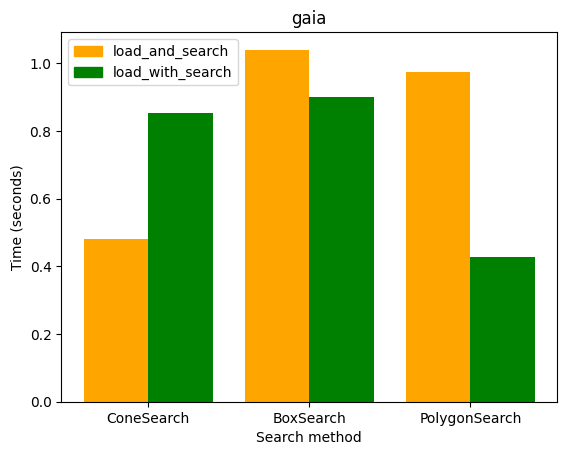

In [23]:
plot_catalog_performance("gaia")

### Key Takeways

Overall, we observe relevant speed-ups when applying the spatial filters with the new strategy (up to ~50%). We reduce the amount of time it takes to lazily load a catalog because we are also reducing the number of tasks embedded in the Dask task graph.

The performance gains with prefiltering do not seem to be directly proportional to the number of catalog partitions - the best performance improvements were with `ztf_zource` (~40 thousand partitions). This leads us to believe that we will notice a sharper speedup when reading catalog subsets when the number of partitions matches this order of magnitude. When the catalog is smaller we might observe that prefiltering can at times be slower (e.g. the cone search on `gaia`), but it won't be as noticeable because the difference is within fractions of seconds.